# DIP Exercise 10

In [2]:
# Load packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import h5py
import cv2

from scipy import ndimage
from scipy.ndimage import gaussian_filter, distance_transform_edt

from skimage import morphology
from skimage import io
from skimage.morphology import binary_erosion, disk
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed, find_boundaries
from skimage.measure import label

from ipywidgets import interact, IntSlider

np.random.seed(42)

# Morphological opening

Consider this binary image with circular objects that is inspired by the Nebra sky disc, an approximately 4000 years old archaeological specimen. We are pretty sure that the copyright has expired a long time ago...

考虑这张圆形物体的双星图像，它的灵感来自于内布拉天盘，一个大约4000年前的考古标本。我们很确定版权早就过期了……

[0 1]


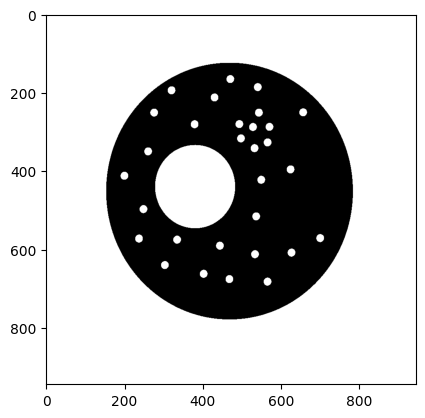

In [3]:
circles = cv2.imread(r'./data/nebra.png', cv2.IMREAD_GRAYSCALE)
th, circles = cv2.threshold(circles, 128, 1, cv2.THRESH_BINARY)   #阈值
print(np.unique(circles))

plt.imshow(circles, cmap='gray')
plt.show()

<img src='.\data\exclamation_sign.png' width=20px height=20px style="float:left;"> 
Explain the morphological opening operation!

Erosion of an image l with a structuring element E, followed by dilation with E

开操作=先腐蚀再膨胀

<img src='.\data\exclamation_sign.png' width=20px height=20px style="float:left;">
Remove selectively only the small, white circles in the image below by morphological opening!

通过形态学打开，选择性地删除下图中的白色小圆圈!

Text(0.5, 1.0, 'opening operation from cv2')

<Figure size 8000x8000 with 0 Axes>

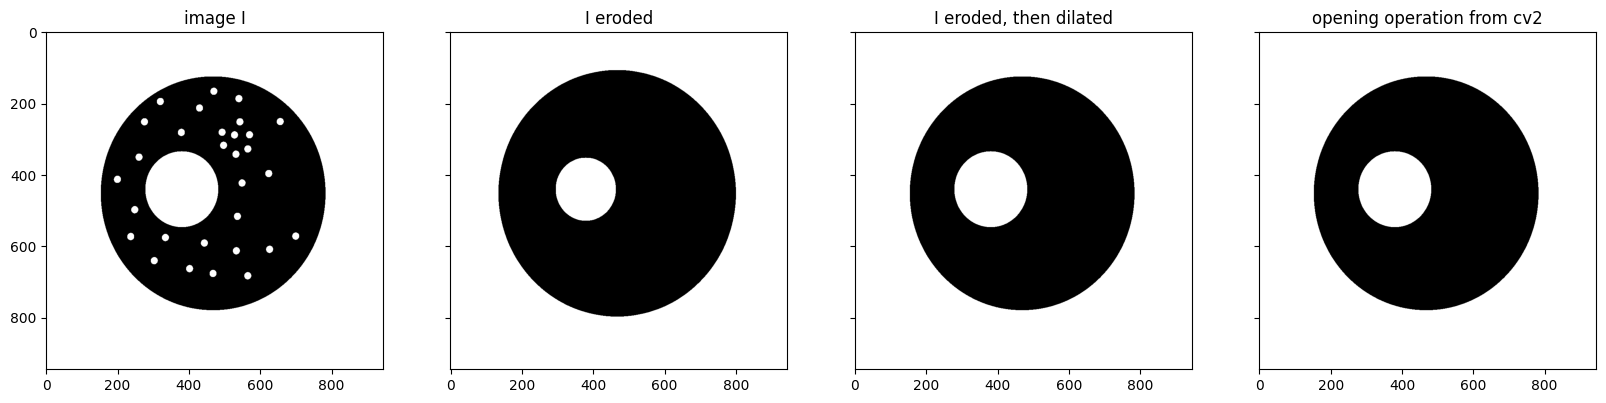

In [4]:
# TODO: your code here:
# structuring elements can be defined with "morphology.disk(xx)", where xx is  the radius of the disk-shaped SE.
# erosion/dilation are implemented in opencv with the commands cv2.erode(inputImage, SE, 1) and cv2.dilate(inputImage, SE, 1)

#kernel = ???
#eroded = ???
#dilated = ???
kernel = morphology.disk(18)
eroded = cv2.erode(circles, kernel, 1)
dilated = cv2.dilate(eroded, kernel, 1)
# plotting and validation
opening = cv2.morphologyEx(circles, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=[80,80])
fig, axes = plt.subplots(1, 4, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(circles, cmap='gray')
ax[0].set_title('image I')
ax[1].imshow(eroded, cmap='gray')
ax[1].set_title('I eroded')
ax[2].imshow(dilated, cmap='gray')
ax[2].set_title('I eroded, then dilated')
ax[3].imshow(opening, cmap='gray')
ax[3].set_title('opening operation from cv2')

<img src='.\data\question_sign.png' width=20px height=20px style="float:left;"> 
What will be the result of performing morphological opening several times in a row? 

连续进行几次形态打开会有什么结果?


For example, assuming we have an image I and a structuring element E: opening(opening(opening(I,E),E),E)

Give reasons!

Morphological opening is **idempotent**, i.e. if we perform the same opening operation again on the output of the first openingoperation, the result will not change. The reason is that morphological opening removes all structures in the image I that aresmaller than the structuring element E, while leaving the larger structures intact. Already the first opening wil remove all thesmall structures.


形态学打开是幂等的，即如果我们在第一次打开操作的输出上再次执行相同的打开操作，结果将不会改变。原因是形态学开放去除了图像I中小于结构元素E的所有结构，而保留了较大的结构。第一个开口就能清除所有的小结构。

Text(0.5, 1.0, 'multiple openings')

<Figure size 2000x2000 with 0 Axes>

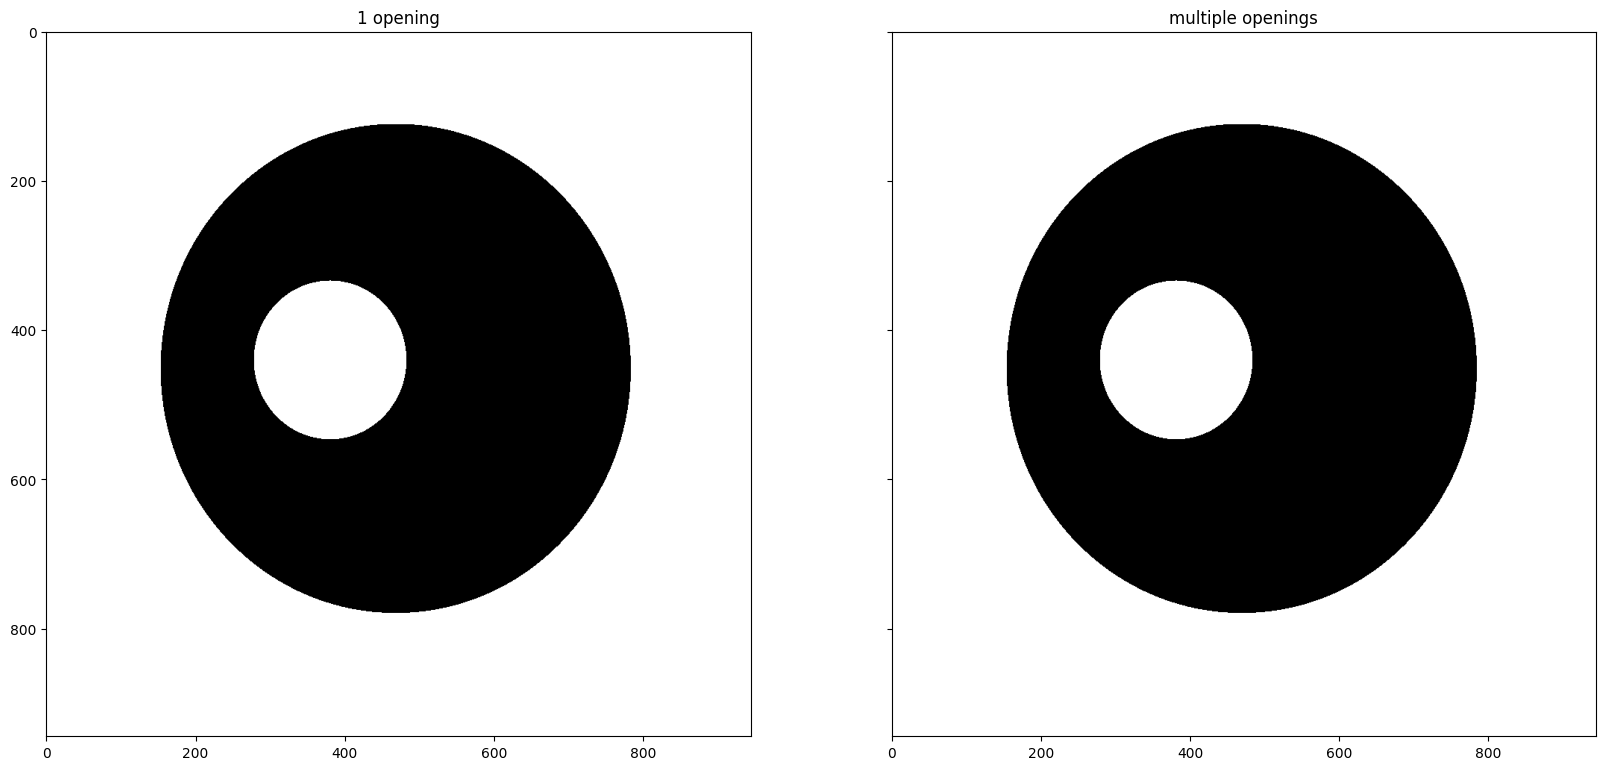

In [8]:
#This can also be verified in practice:
opening = cv2.morphologyEx(circles, cv2.MORPH_OPEN, kernel)
opening_mult = opening.copy()

## TODO: apply multiple openings with the same SE to opening_mult image!

for i in range(5):
    opening_mult = cv2.morphologyEx(opening_mult, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=[20,20])
fig, axes = plt.subplots(1, 2, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(opening, cmap='gray')
ax[0].set_title('1 opening')
ax[1].imshow(opening_mult, cmap='gray')
ax[1].set_title('multiple openings')

# Boundary

<img src='.\data\exclamation_sign.png' width=20px height=20px style="float:left;"> Trace the boundaries/the outlines of the circles using morphological operations!

使用形态学操作追踪圆圈的边界/轮廓!

Text(0.5, 1.0, 'dilated - eroded')

<Figure size 8000x8000 with 0 Axes>

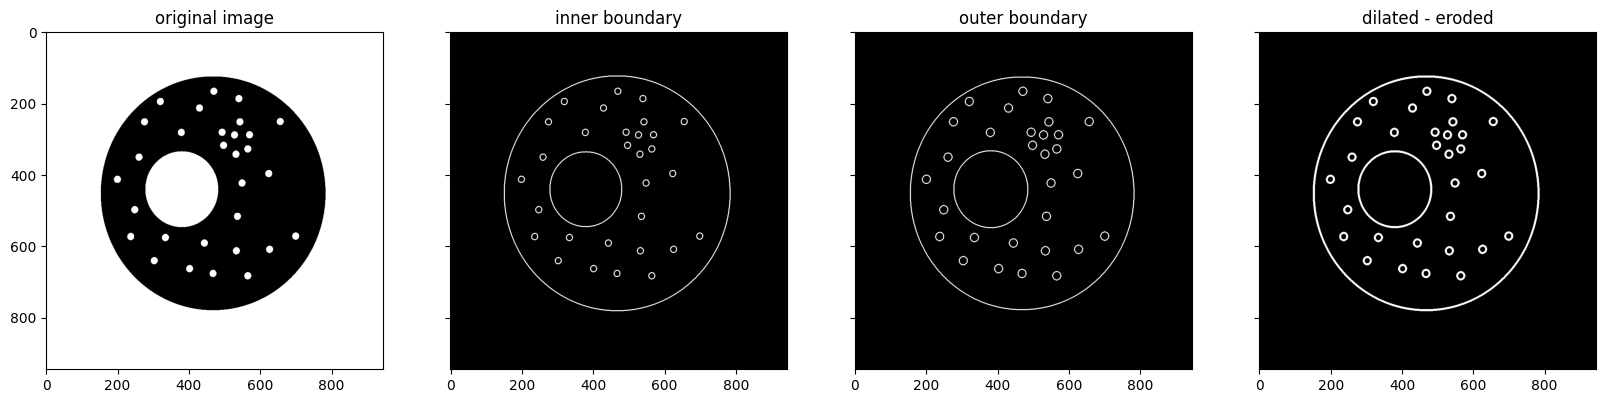

In [9]:
# define the kernel
kernel2 = morphology.disk(3)

#your code here:
# TODO: inner boundary: 
kernel2 = morphology.disk(3)
erosion = cv2.erode(circles, kernel2, 1)
outlines = circles - erosion

# TODO: outer boundary:
dilation = cv2.dilate(circles, kernel2, 1)
outlines2 = dilation - circles

# TODO: dilated - eroded version of the image:
outlines3 = dilation - erosion

plt.figure(figsize=[80,80])
fig, axes = plt.subplots(1, 4, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(circles, cmap='gray')
ax[0].set_title('original image')
ax[1].imshow(outlines, cmap='gray')
ax[1].set_title('inner boundary')
ax[2].imshow(outlines2, cmap='gray')
ax[2].set_title('outer boundary')
ax[3].imshow(outlines3, cmap='gray')
ax[3].set_title('dilated - eroded')


# Connected components

Consider a modified image with higher morphological complexity:

考虑一个形态学复杂度更高的修改后的图像:

[0 1]


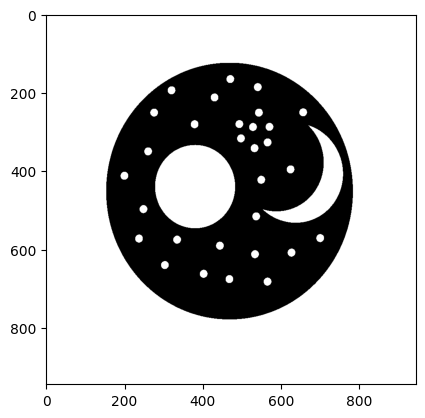

In [10]:
I = cv2.imread(r'./data/nebra_moon.png', cv2.IMREAD_GRAYSCALE)
th, I = cv2.threshold(I, 128, 1, cv2.THRESH_BINARY)
print(np.unique(I))

plt.imshow(I, cmap='gray')
plt.show()

<img src='.\data\question_sign.png' width=20px height=20px style="float:left;"> Given the modified image I, could we still selectively remove the small, white circles by morphological opening? Describe which problem could occur!

对于修改后的图像I，我们是否仍然可以通过形态学打开选择性地去除小的白色圆圈?描述可能发生的问题!


Removing the small, white circles is still possible, however the opening operation would damage the thin ends of the lunar crescent. 

移除白色的小圆圈仍然是可能的，但是打开的操作会损坏新月的细端。

Text(0.5, 1.0, 'opening')

<Figure size 4000x4000 with 0 Axes>

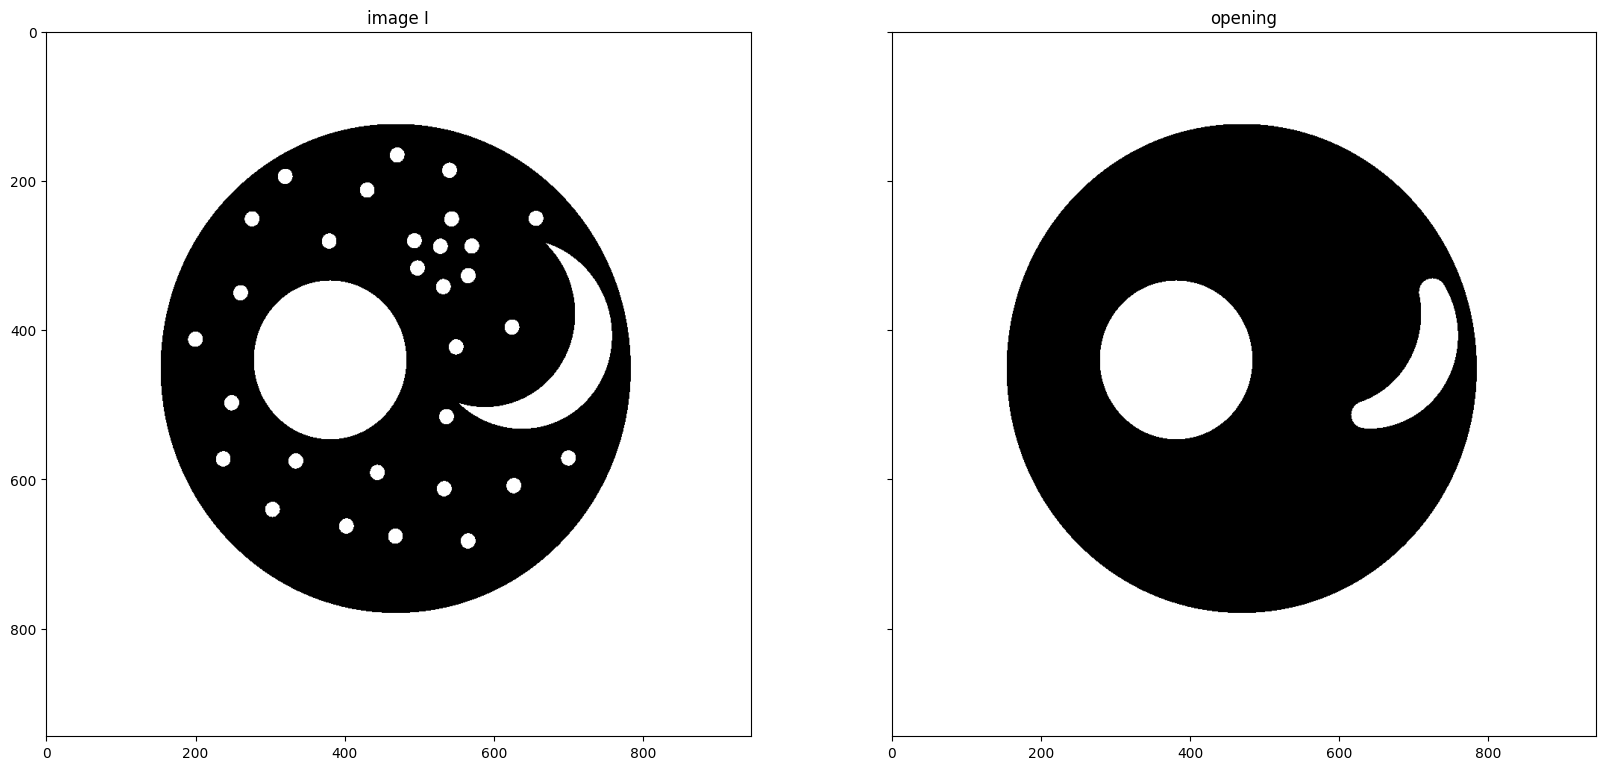

In [11]:
#Again, we can verify this in practice:
I_opened = cv2.morphologyEx(I, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=[40,40])
fig, axes = plt.subplots(1, 2, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(I, cmap='gray')
ax[0].set_title('image I')
ax[1].imshow(I_opened, cmap='gray')
ax[1].set_title('opening')

#Results could be improved by choosing a better kernel/structuring element, but the crescent remains a problem.

An alternative, and presumably better, solution can be achieved with connected components.

另一种可能更好的解决方案可以通过连接组件来实现。

<img src='.\data\exclamation_sign.png' width=20px height=20px style="float:left;"> 
Assume that we know one pixel from each connected component in the image I. Describe the connected components algorithm for this scenario!

假设我们知道图像1中每个连接组件的一个像素。描述这个场景的连接组件算法!

**有种子**

Given:
    image I
    kernel/structuring element E
    seed pixel for each connected component  每个连接组件的种子像素
For one connected component:
    intialize: Let X_0 be an image of the same size as I that is filled with zeros, but that is 1 at the location of the seed pixel  设X_0为与I大小相同的图像，填充为0，但在种子像素位置为1
    iterate: X_k = intersect( dilate(X_{k-1}, E), I)  迭代:X_k = intersect(dilate(X_{k-1}， E)， I)   对上一轮迭代的结果 X_{k-1} 进行膨胀操作，然后与输入图像 I 取交集。这个操作有助于逐步扩展连接组件的分割区域。
    terminate if X_k == X_{k-1}

<img src='.\data\question_sign.png' width=20px height=20px style="float:left;"> 
Assume that we do not yet know the seed pixel for each connected component. How would we need to modify the connected components algorithm?

假设我们还不知道每个连接组件的种子像素。我们需要如何修改连接组件算法?

**没种子**

select any foreground pixel with value=1: this pixel is located inside an object (with a size of a least 1 pixel) and thusquaranteed to be a seed pixel for one connected component

run the connected components algorithm described above for this one component and seed pixel

remove all pixels belonging to the detected component from image l by setting them to 0 (background

repeat until no foreground values(1) are left in l

选择任何值=1的前景像素:该像素位于对象内部(大小至少为1像素)，因此保证是一个连接组件的种子像素

对这一个组件和种子像素运行上面描述的连接组件算法

通过将其设置为0(背景)，从图像1中移除属于检测组件的所有像素

重复，直到没有前景值(1)在1中留下

<img src='.\data\exclamation_sign.png' width=20px height=20px style="float:left;"> Employ the connected components algorithm to selectively remove the small, white circles from the image I! 

采用连通分量算法有选择地从图像中去除小的白色圆圈。

Hint: cv2.connectedComponents()

Text(0.5, 1.0, 'solution 2)')

<Figure size 6000x6000 with 0 Axes>

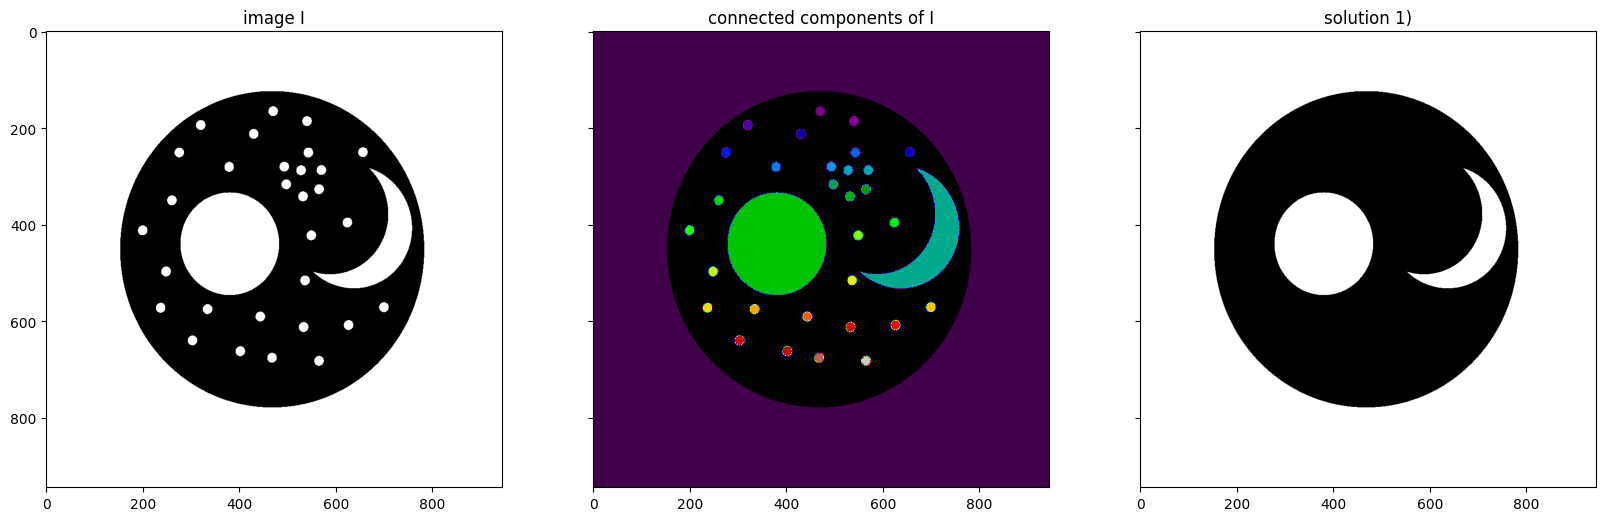

<Figure size 6000x6000 with 0 Axes>

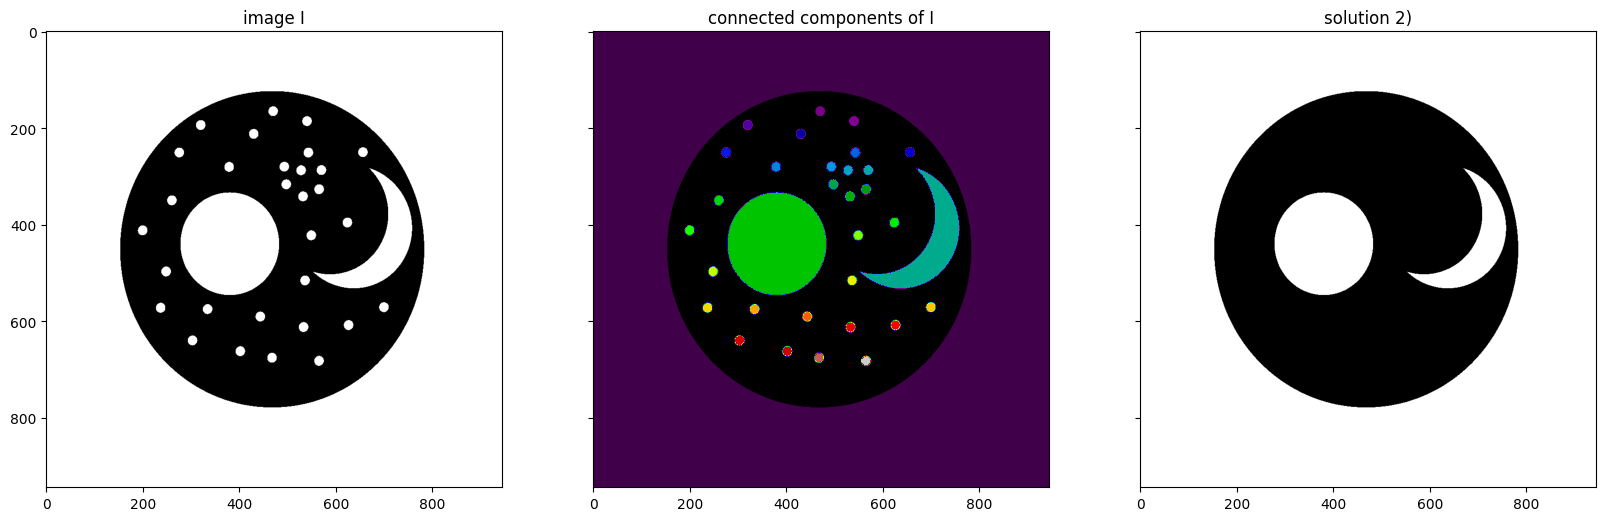

In [13]:
#your code here

#1) Discard connected components with a size < size_threshold
size_threshold = 500

num_cc, cc = cv2.connectedComponents(I)
cc_filtered = np.zeros(cc.shape)

# TODO: fill the cc_filtered image only with the connected components that are below the threshold!
### ...
for i in range(num_cc):
    positions = np.where(cc == i)
    num_pixels = np.size(positions[0])
    if num_pixels < size_threshold:
        cc_filtered[positions] = 1

# compute result image by removing the identified small circles
I_prime = I-cc_filtered

# plot the results
plt.figure(figsize=[60,60])
fig, axes = plt.subplots(1, 3, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(I, cmap='gray')
ax[0].set_title('image I')
ax[1].imshow(cc, cmap='nipy_spectral')
ax[1].set_title('connected components of I')
ax[2].imshow(I_prime, cmap='gray')
ax[2].set_title('solution 1)')

###

#2) Alternative solution without a size threshold:
num_cc, cc = cv2.connectedComponents(I)
cc_filtered = np.zeros(cc.shape)
diff = I-I_opened #image - opened image

# TODO: discard only objects that are completely removed by the opening (size in diff == size in cc):
# ...
for i in range(num_cc):
    positions = np.where(cc == i)
    s = np.sum(diff[positions])
    num_pixels = np.size(positions[0])
    if s==num_pixels:
        cc_filtered[positions] = 1


I_prime = I-cc_filtered

plt.figure(figsize=[60,60])
fig, axes = plt.subplots(1, 3, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(I, cmap='gray')
ax[0].set_title('image I')
ax[1].imshow(cc, cmap='nipy_spectral')
ax[1].set_title('connected components of I')
ax[2].imshow(I_prime, cmap='gray')
ax[2].set_title('solution 2)')

# Skeletonization  #骨架化

As we have seen in the lecture, connected components and several other high-level operations can be implemented using low-level morphological operators. A further example is skeletonization that can be computed through a series of erosion and opening operations:

- given: image A, kernel/structuring elemt B, k: number of iterations/erosions
- result: skeleton S(A)

- S_k(A) = erode(A,kB) − open(erode(A,kB)), B)
- S(A) is the union of all S_k, k=1, ..., K

- K is defined as the last iteration before the erosion returns an empty set



正如我们在讲座中看到的，连接组件和其他一些高级操作可以使用低级形态操作符来实现。另一个例子是骨架化，可以通过一系列侵蚀和打开操作来计算:

-给定:图像A，内核/结构元素B, k:迭代/侵蚀次数

-结果:骨架S(A)

—S_k(A) = erosion (A,kB)−open(erosion (A,kB))， B)
- S(A)是所有S_k的并集，k=1，…K

- K定义为侵蚀返回空集之前的最后一次迭代

<img src='.\data\question_sign.png' width=20px height=20px style="float:left;"> 
Before you execute the code below, can you predict how image I will look like after skeletonization using a 3x3 square structuring element?

在执行下面的代码之前，您能预测使用3x3方形结构元素进行骨架化后的图像是什么样子吗?

Text(0.5, 1.0, 'skeleton of I')

<Figure size 4000x4000 with 0 Axes>

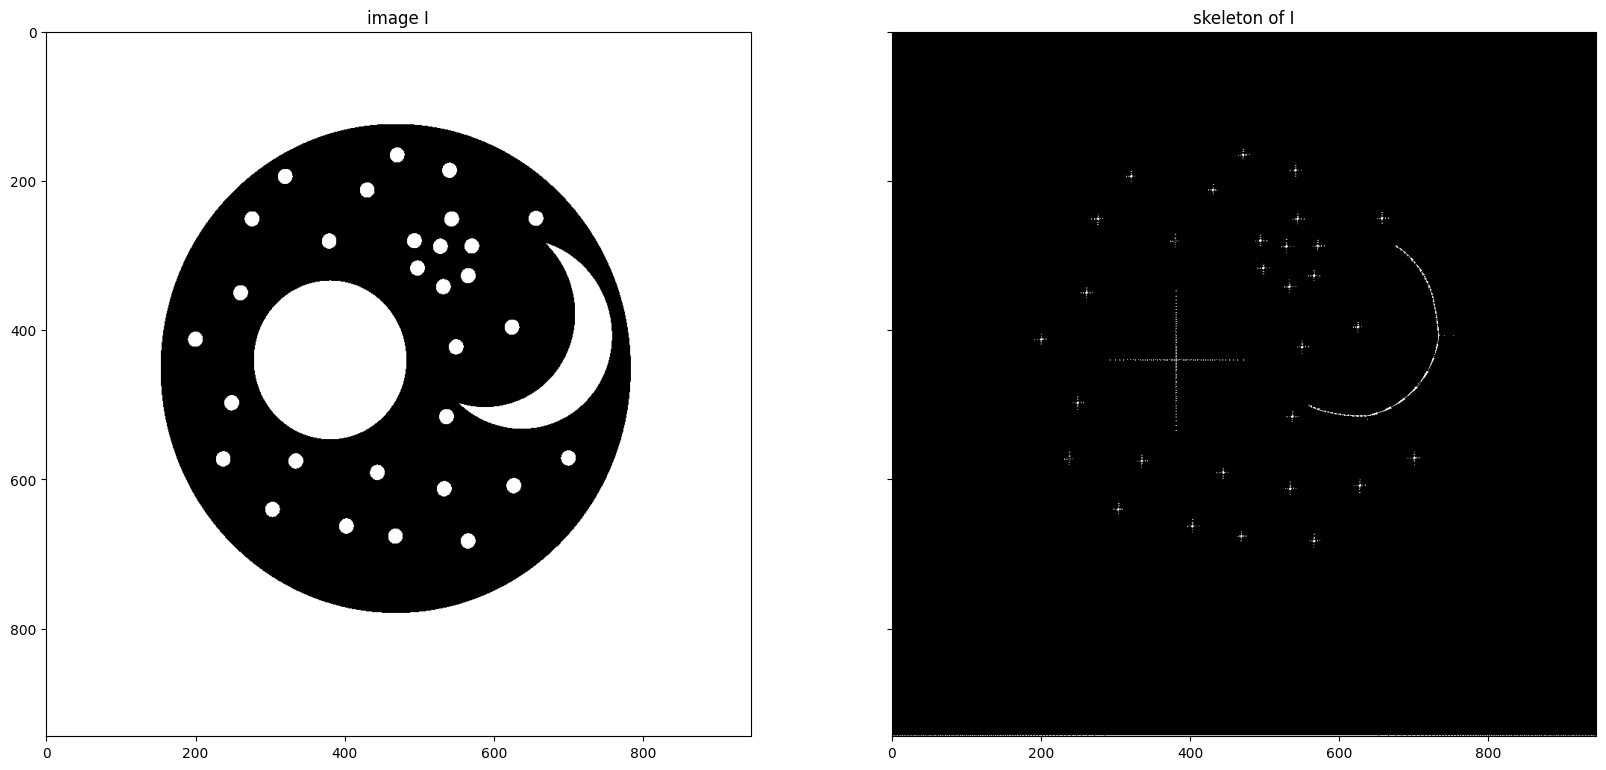

In [14]:
A = I.copy() 
#intialize an empty skeleton image:
skeleton = I.copy()
skeleton[:,:] = 0
B = np.ones((3,3)) #the structuring element

while cv2.countNonZero(A)>0: #check: empty set?
    eroded = cv2.morphologyEx(A, cv2.MORPH_ERODE, B)
    opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, B)
    difference = cv2.subtract(eroded, opened) #eroded - open(eroded)
    skeleton = cv2.bitwise_or(skeleton, difference) #set union
    A = eroded
    
plt.figure(figsize=[40,40])
fig, axes = plt.subplots(1, 2, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(I, cmap='gray')
ax[0].set_title('image I')
ax[1].imshow(skeleton, cmap='gray')
ax[1].set_title('skeleton of I') 

# Cell membranes   #细胞膜

Now, we don't want to disturb your circles, but we would nevertheless like to ask you to apply your knowledge to biological image segmentation. The image below shows cell membranes and an instance segmentation mask where all pixels from one cell are assigned the same, distinct value.

现在，我们不想打扰你的圈子，但我们还是想请你把你的知识应用到生物图像分割上。下图显示了细胞膜和一个实例分割掩码，其中来自一个细胞的所有像素都被分配了相同的不同值。

<Figure size 1600x1200 with 0 Axes>

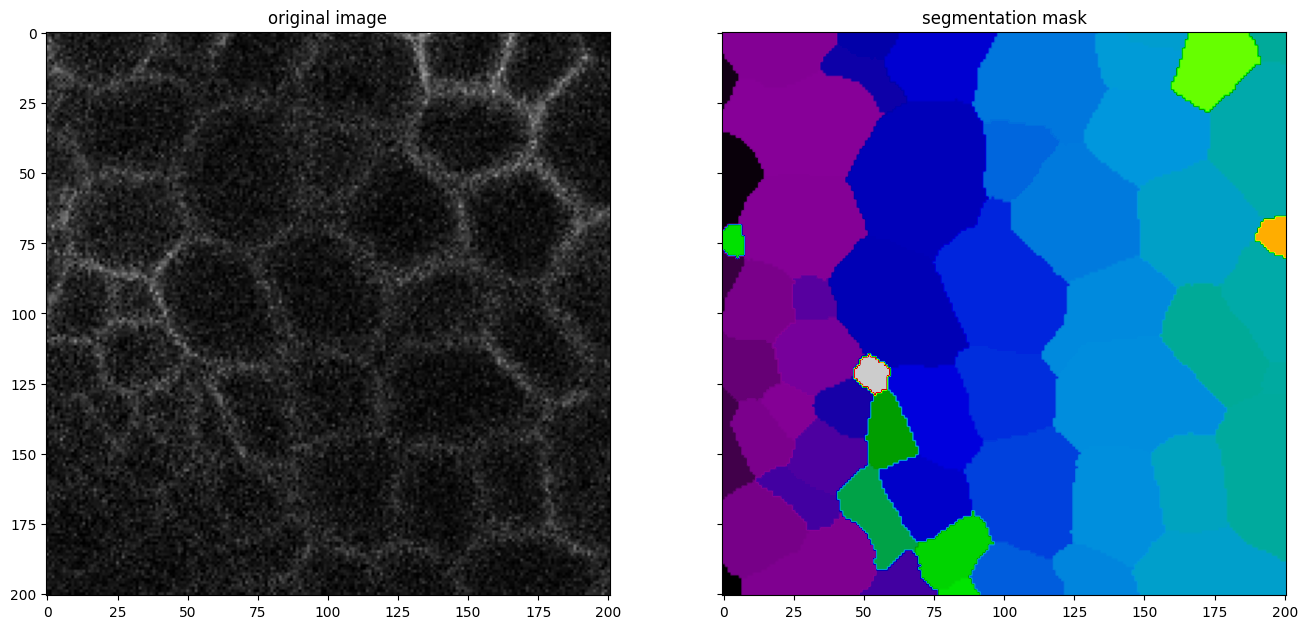

In [15]:
#image:
with h5py.File(r'./data/PNAS_meristem/thaliana_membranes_48h.h5', 'r') as h5_handle:
    img = np.array(h5_handle['data/image'])
    img = np.transpose(img, axes=(2,1,0))

#matching instance segmentation:    
with h5py.File(r'./data/PNAS_meristem/thaliana_instances_48h.h5', 'r') as h5_handle:
    instances = np.array(h5_handle['data/instances'])
    instances = np.transpose(instances, axes=(2,1,0))

#get a patch from the image:
patch_size = [201, 201, 201]
instances_patch = instances[:patch_size[0], instances.shape[1]-patch_size[1]:instances.shape[1], :patch_size[2]]
corresponding_patch = img[:patch_size[0], instances.shape[1]-patch_size[1]:instances.shape[1], :patch_size[2]]
    
membrane_image = corresponding_patch[...,0]
segmentation = instances_patch[...,0]
    
plt.figure(figsize=[16,12])
fig, axes = plt.subplots(1, 2, figsize=[16, 8], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(membrane_image, cmap='gray')
ax[0].set_title('original image')
ax[1].imshow(segmentation, cmap='nipy_spectral')
ax[1].set_title('segmentation mask')
plt.show()

<img src='.\data\exclamation_sign.png' width=20px height=20px style="float:left;"> 
Use one or more morphological operation(s) to extract the membrane outlines (i.e. the cell boundaries) from the instance segmentation mask!

使用一个或多个形态学操作从实例分割掩码中提取膜轮廓(即细胞边界)!

<Figure size 8000x8000 with 0 Axes>

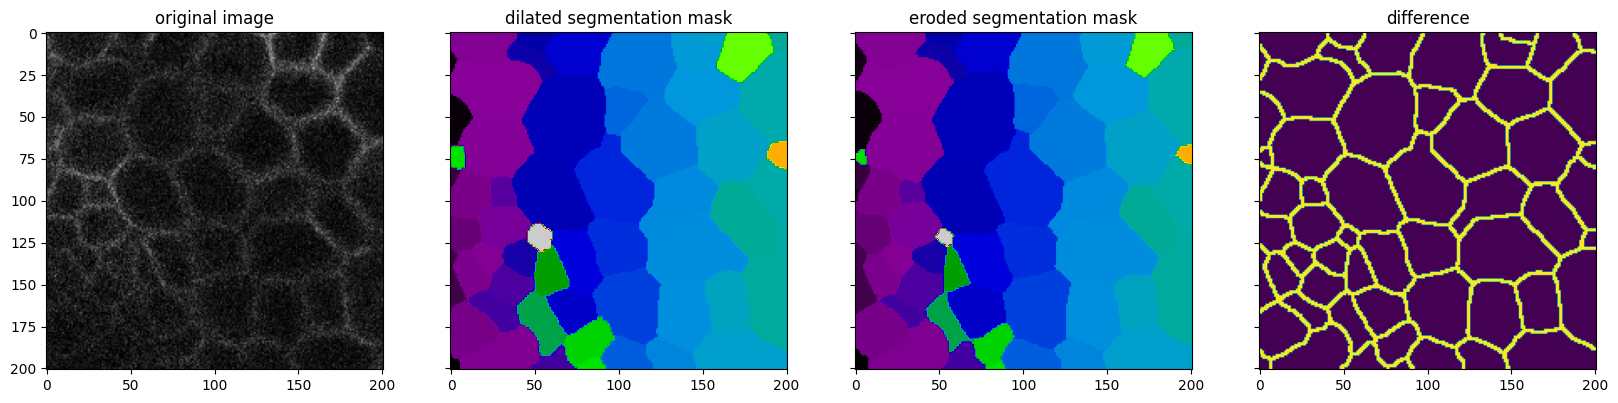

<Figure size 8000x8000 with 0 Axes>

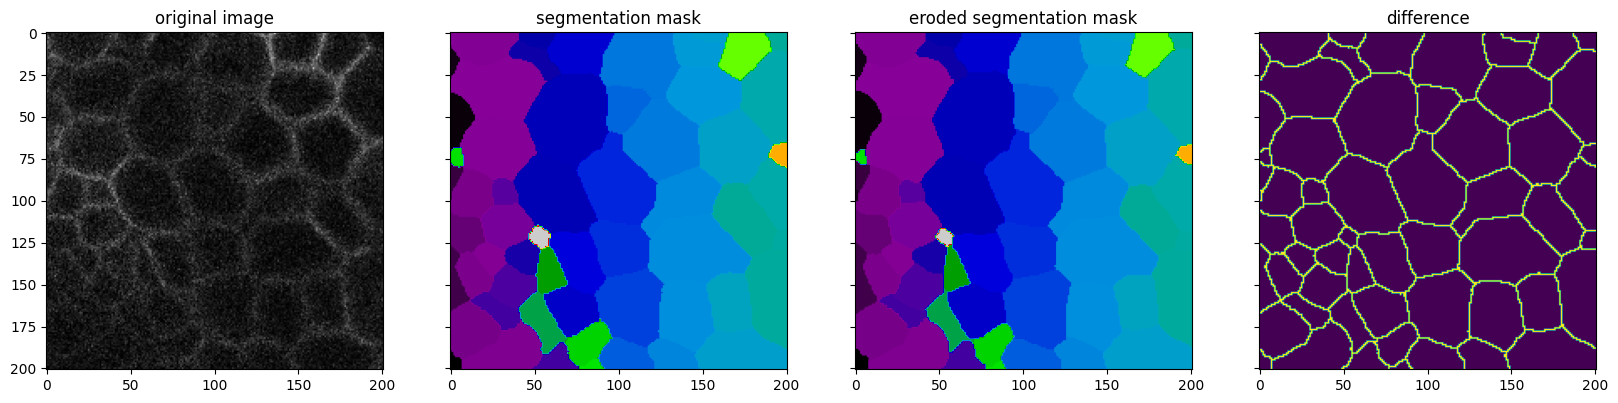

In [16]:
#your code here:

#We can use the same strategies as for tracing the circle boundaries above, so there are multiple solutions.
#Note: Different from the circle boundary example, the segmentation map is not a binary image.

#TODO: version 1) B:= M_dilated - M_eroded 
kernel3 = np.ones((3,3))
segmentation_eroded = cv2.erode(segmentation, kernel3, iterations=1)
segmentation_dilated = cv2.dilate(segmentation, kernel3, iterations=1)
boundaries = segmentation_dilated - segmentation_eroded

#Then, B is binarized:
boundaries[boundaries>0] = 1 

plt.figure(figsize=[80,80])
fig, axes = plt.subplots(1, 4, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(membrane_image, cmap='gray')
ax[0].set_title('original image')
ax[1].imshow(segmentation_dilated, cmap='nipy_spectral')
ax[1].set_title('dilated segmentation mask')
ax[2].imshow(segmentation_eroded, cmap='nipy_spectral')
ax[2].set_title('eroded segmentation mask')
ax[3].imshow(boundaries)
ax[3].set_title('difference')
plt.show()

####

# TODO: version 2) B:= M - M_eroded
kernel3 = np.ones((3,3))
segmentation_eroded = cv2.erode(segmentation, kernel3, iterations=1)
boundaries = segmentation - segmentation_eroded

#Then, B is binarized:
boundaries[boundaries>0] = 1 

plt.figure(figsize=[80,80])
fig, axes = plt.subplots(1, 4, figsize=[20,20], sharex=True, sharey=True)
ax = axes.flat
ax[0].imshow(membrane_image, cmap='gray')
ax[0].set_title('original image')
ax[1].imshow(segmentation, cmap='nipy_spectral')
ax[1].set_title('segmentation mask')
ax[2].imshow(segmentation_eroded, cmap='nipy_spectral')
ax[2].set_title('eroded segmentation mask')
ax[3].imshow(boundaries)
ax[3].set_title('difference')
plt.show()